In [55]:
# Load seed 21 results and combine them into one csv

import pandas as pd
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# === Step 1: Define folder and categorize CSV files ===
folder = "optimization_150000_seed21_results"
files = os.listdir(folder)

# Group files by scenario label prefix
favourable_files = [f for f in files if f.startswith("favourable_outcomes")]
unfavourable_files = [f for f in files if f.startswith("unfavourable_outcomes")]
medium_files = [f for f in files if f.startswith("medium_outcomes")]

# === Step 2: Helper function to load CSV files and combine them with labels ===
def load_and_combine(file_list, label):
    dfs = []
    run = 0
    for file in file_list:
        df = pd.read_csv(os.path.join(folder, file))
        # Calculate total investment costs
        df['Total Investment Costs'] = (
            df['Dike Investment Costs'] +
            df['RfR Investment Costs']
        )
        df['Expected Annual Costs'] = (
            df['Evacuation Costs'] +
            df['Expected Annual Damage']
        )
        # Add a scenario label column
        df[f'Scenario'] = label + f'_{run}'
        run += 1
        dfs.append(df)
    # Combine all dataframes into one
    return pd.concat(dfs, ignore_index=True)

# === Step 3: Load and combine dataframes for each scenario type ===
favourable_df_21 = load_and_combine(favourable_files, 'Favourable')
unfavourable_df_21 = load_and_combine(unfavourable_files, 'Unfavourable')
medium_df_21 = load_and_combine(medium_files, 'Medium')

# Show first rows of medium scenario dataframe
medium_df_21.head()


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs,Expected Annual Costs,Scenario
0,0,1,0,0,0,0,1,1,0,0,...,0,0,1.351245e+08,3.667233e+07,146000000.0,0.0,0.093794,1.826723e+08,1.351245e+08,Medium_0
1,0,1,1,0,0,0,0,1,0,0,...,0,0,7.152996e+08,0.000000e+00,199900000.0,0.0,0.620578,1.999000e+08,7.152996e+08,Medium_0
2,0,0,1,0,0,0,1,0,0,1,...,0,0,2.467534e+08,0.000000e+00,236500000.0,0.0,0.192439,2.365000e+08,2.467534e+08,Medium_0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,1.918775e+08,2.503721e+07,205800000.0,0.0,0.145112,2.308372e+08,1.918775e+08,Medium_0
4,0,1,0,0,0,0,1,0,1,0,...,0,0,7.347813e+08,0.000000e+00,146000000.0,0.0,0.627542,1.460000e+08,7.347813e+08,Medium_0


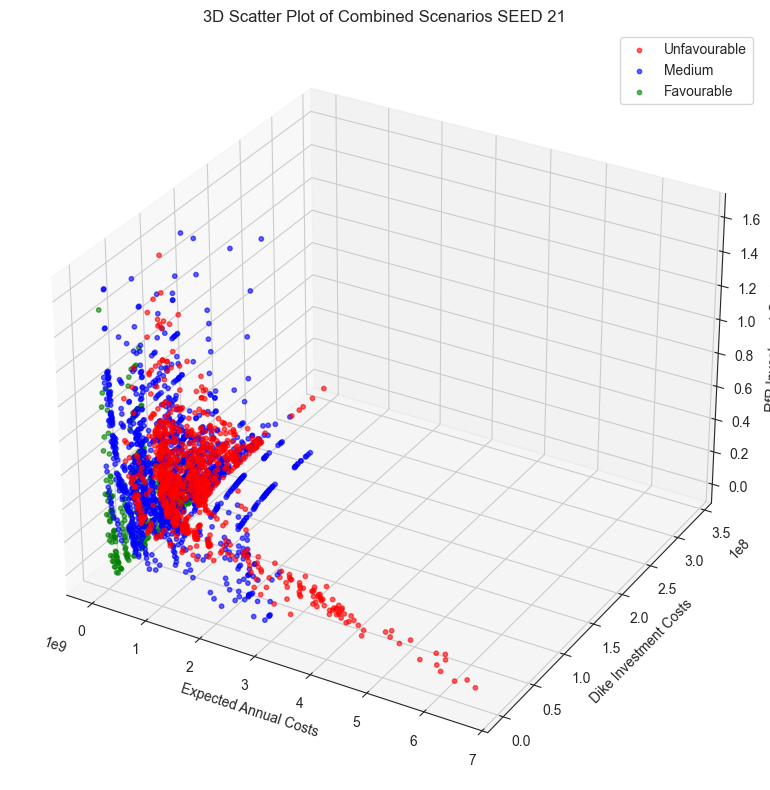

In [56]:
# Plot in 3D with each scenario group shown in a different color

# === Step 4: Plot setup ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points for the Unfavourable scenario group in red
ax.scatter(
    unfavourable_df_21['Expected Annual Costs'],
    unfavourable_df_21['Dike Investment Costs'],
    unfavourable_df_21['RfR Investment Costs'],
    color='red', label='Unfavourable', alpha=0.6, s=10
)

# Plot points for the Medium scenario group in blue
ax.scatter(
    medium_df_21['Expected Annual Costs'],
    medium_df_21['Dike Investment Costs'],
    medium_df_21['RfR Investment Costs'],
    color='blue', label='Medium', alpha=0.6, s=10
)

# Plot points for the Favourable scenario group in green
ax.scatter(
    favourable_df_21['Expected Annual Costs'],
    favourable_df_21['Dike Investment Costs'],
    favourable_df_21['RfR Investment Costs'],
    color='green', label='Favourable', alpha=0.6, s=10
)



# Set axis labels
ax.set_xlabel('Expected Annual Costs')
ax.set_ylabel('Dike Investment Costs')
ax.set_zlabel('RfR Investment Costs')

# Add legend and title
ax.legend()
plt.title('3D Scatter Plot of Combined Scenarios SEED 21')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [57]:
# Define quantiles and filter the dataframe based on these quantiles
# Priority list: Death > Damages > Evac > Costs

# q_total_costs = total investment costs. 75% lowest
# q_dike = dike investment costs. 75% lowest
# q_evac = (annual) evacuation costs. 50% lowest
# q_damage = total annual damage costs. 25% lowest
# death_cap = max number of deaths. 0.01

def load_thresholds(df, q_investment_costs=0.75, q_dike=0.75, q_evac=0.50,  q_damage = 0.25, death_cap=0.02):
    # Calculate total costs as sum of relevant cost columns
    df['Total Investment Costs'] = (
        df['Dike Investment Costs'] +
        df['RfR Investment Costs']
    )

    # Return dataframe and a dictionary with threshold values (quantiles for costs, fixed cap for deaths)
    return df, {
        'Total Investment Costs': df['Total Investment Costs'].quantile(q_investment_costs),
        'Dike Investment Costs': df['Dike Investment Costs'].quantile(q_dike),
        'Evacuation Costs': df['Evacuation Costs'].quantile(q_evac),
        'Expected Annual Damage': df['Expected Annual Damage'].quantile(q_damage),
        'Expected Number of Deaths': death_cap
    }

# Filter the dataframe based on thresholds dictionary
def filter_df(df, thresholds):
    return df[
        (df['Total Investment Costs'] <= thresholds['Total Investment Costs']) &
        (df['Dike Investment Costs'] <= thresholds['Dike Investment Costs']) &
        (df['Evacuation Costs'] <= thresholds['Evacuation Costs']) &
        (df['Expected Annual Damage'] <= thresholds['Expected Annual Damage']) &
        (df['Expected Number of Deaths'] <= thresholds['Expected Number of Deaths']) &
        (df['RfR Investment Costs'] > 0)  # Ensure RfR Investment Costs is positive
    ]

In [58]:
# === SELECTING POLICIES BASED ON SCENARIO-SPECIFIC THRESHOLDS ===

# --- Step 1: Load thresholds for the favourable scenario group (SEED 21) ---
fav_df, fav_thresholds = load_thresholds(favourable_df_21)

# --- Step 2: Filter the favourable group DataFrame using those thresholds ---
fav_selected = filter_df(fav_df, fav_thresholds)

# --- Step 3: Display the number of selected policies and a quick preview ---
print(f"Filtered Favourable Policies: {len(fav_selected)} rows")
print(fav_selected[['Total Investment Costs', 'Expected Annual Costs' ,'Expected Number of Deaths', 'Scenario']].head())



Filtered Favourable Policies: 12 rows
     Total Investment Costs  Expected Annual Costs  Expected Number of Deaths  \
134            2.745045e+08           4.220977e+06                   0.008575   
288            2.779232e+08           2.713661e+06                   0.002399   
300            3.611201e+08           3.490520e+06                   0.002743   
309            1.594965e+08           3.655111e+06                   0.002928   
317            3.095280e+08           0.000000e+00                   0.000000   

         Scenario  
134  Favourable_0  
288  Favourable_1  
300  Favourable_1  
309  Favourable_1  
317  Favourable_1  


In [59]:
# === SELECTING POLICIES FOR UNFAVOURABLE SCENARIOS BASED ON THRESHOLDS ===
# These thresholds should ideally be discussed or justified — currently chosen to yield ~5 policies.

# --- Step 1: Load thresholds for the unfavourable scenario group (SEED 21) ---
unfav_df, unfav_thresholds = load_thresholds(unfavourable_df_21)

# --- Step 2: Filter the unfavourable group DataFrame using those thresholds ---
unfav_selected = filter_df(unfav_df, unfav_thresholds)

# --- Step 3: Display the number of selected policies and a preview ---
print(f"Filtered Unfavourable Policies: {len(unfav_selected)} rows")
print(unfav_selected[['Total Investment Costs', 'Expected Annual Costs' ,'Expected Number of Deaths', 'Scenario']].head())


Filtered Unfavourable Policies: 3 rows
     Total Investment Costs  Expected Annual Costs  Expected Number of Deaths  \
681            4.272900e+08           1.527362e+07                   0.007796   
815            3.679542e+08           3.006718e+07                   0.015668   
850            3.481305e+08           3.006718e+07                   0.015668   

           Scenario  
681  Unfavourable_1  
815  Unfavourable_1  
850  Unfavourable_1  


In [60]:
# === SELECTING POLICIES FOR MEDIUM SCENARIOS BASED ON THRESHOLDS ===
# These thresholds should be discussed or justified, currently chosen somewhat arbitrarily to get about 5 policies.

# --- Step 1: Load thresholds for the medium scenario group (SEED 21) ---
med_df, med_thresholds = load_thresholds(medium_df_21)

# --- Step 2: Filter the medium group DataFrame using those thresholds ---
med_selected = filter_df(med_df, med_thresholds)

# --- Step 3: Display the number of selected policies and preview some columns ---
print(f"Filtered Medium Policies: {len(med_selected)} rows")
print(med_selected[['Total Investment Costs', 'Expected Annual Costs' ,'Expected Number of Deaths', 'Scenario']].head())


Filtered Medium Policies: 72 rows
     Total Investment Costs  Expected Annual Costs  Expected Number of Deaths  \
36             3.241074e+08           1.736627e+07                   0.017784   
85             3.221455e+08           1.856612e+07                   0.013991   
97             3.273071e+08           1.232490e+07                   0.010452   
120            3.167691e+08           1.850801e+07                   0.017990   
121            4.752873e+08           7.489105e+06                   0.005451   

     Scenario  
36   Medium_0  
85   Medium_0  
97   Medium_0  
120  Medium_0  
121  Medium_0  


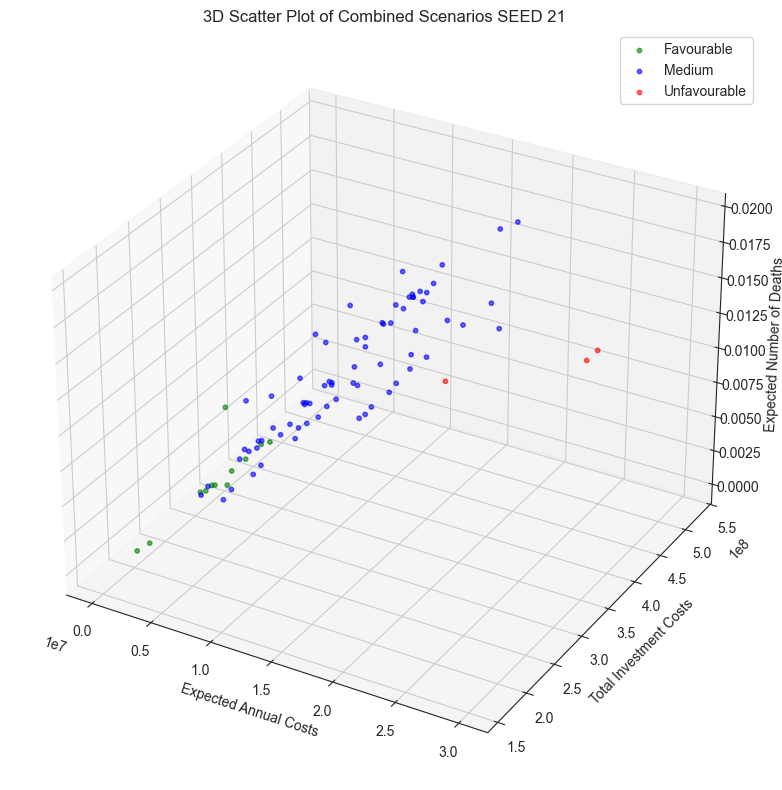

In [61]:
# Create a 3D scatter plot of the selected policies from different scenarios
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot favourable policies in green
ax.scatter(fav_selected['Expected Annual Costs'],
           fav_selected['Total Investment Costs'],
           fav_selected['Expected Number of Deaths'],
           color='green', label='Favourable', alpha=0.6, s=10)

# Plot medium policies in blue
ax.scatter(med_selected['Expected Annual Costs'],
           med_selected['Total Investment Costs'],
           med_selected['Expected Number of Deaths'],
           color='blue', label='Medium', alpha=0.6, s=10)

# Plot unfavourable policies in red
ax.scatter(unfav_selected['Expected Annual Costs'],
           unfav_selected['Total Investment Costs'],
           unfav_selected['Expected Number of Deaths'],
           color='red', label='Unfavourable', alpha=0.6, s=10)

# Set axis labels and show legend
ax.set_xlabel('Expected Annual Costs')
ax.set_ylabel('Total Investment Costs')
ax.set_zlabel('Expected Number of Deaths')
ax.legend()

plt.title('3D Scatter Plot of Combined Scenarios SEED 21')
plt.tight_layout()
plt.show()


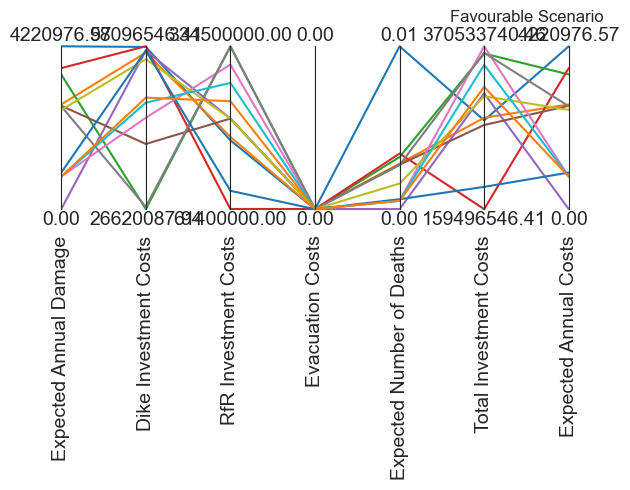

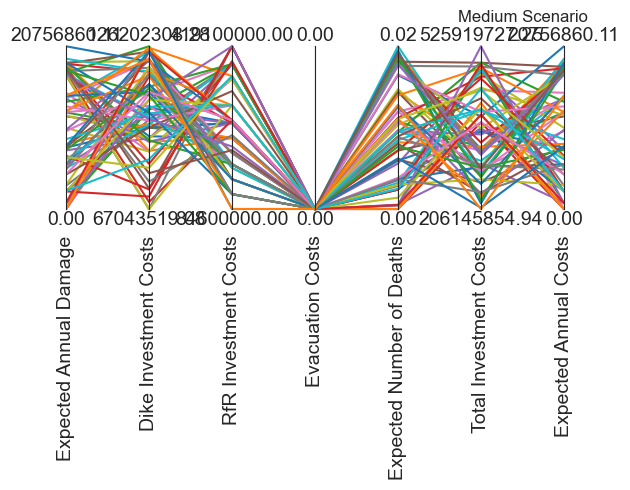

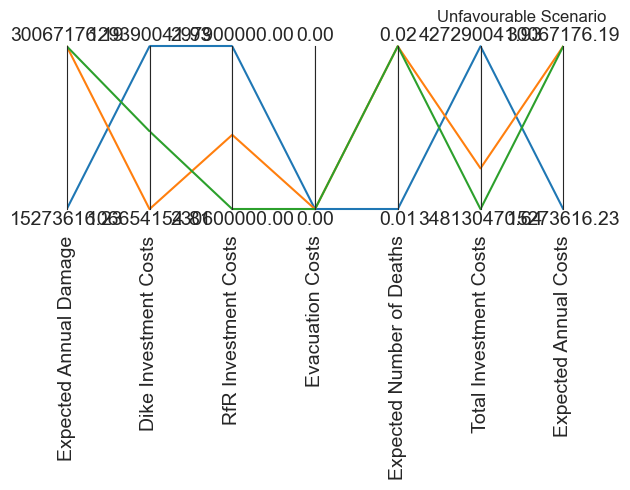

In [62]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

def plot_parallel_coords(metrics_df, title="Parallel Coordinates Plot"):
    # Select only the last 7 columns from the dataframe
    df_subset = metrics_df.iloc[:, -8:]

    # Keep only numeric columns to avoid issues with non-numeric data like 'scenario'
    df_numeric = df_subset.select_dtypes(include=['number'])

    # Generate axis limits and create the parallel coordinates plot
    limits = parcoords.get_limits(df_numeric)
    axes = parcoords.ParallelAxes(limits)
    axes.plot(df_numeric)

    plt.title(title)
    plt.show()

# Plot parallel coordinates for each scenario group
plot_parallel_coords(fav_selected, "Favourable Scenario")
plot_parallel_coords(med_selected, "Medium Scenario")
plot_parallel_coords(unfav_selected, "Unfavourable Scenario")


In [50]:
# Define sort order: ascending = True means lower values are better
sort_columns = [
    'Expected Number of Deaths',
    'Expected Annual Damage',
    'Evacuation Costs',
    'Total Investment Costs'
]

# Sort each DataFrame and select top 3
fav_top3 = fav_selected.sort_values(by=sort_columns).head(3)
med_top3 = med_selected.sort_values(by=sort_columns).head(3)
unfav_top3 = unfav_selected.sort_values(by=sort_columns).head(3)

fav_top3['Scenario'] = 'Favorable'
med_top3['Scenario'] = 'Middle'
unfav_top3['Scenario'] = 'Unfavorable'

# Combine the top 3 from each into a single DataFrame
combined_top_policies = pd.concat([fav_top3, med_top3, unfav_top3], ignore_index=True)


In [51]:
import os
from datetime import datetime

# === Function to save filtered policy DataFrames as CSV files ===
def save_policy_csv(results_df, prefix, save=True):
    # Extract policy columns (exclude last 7 outcome columns)
    policy = results_df.iloc[:, :-8]

    # Format current date for filename
    current_date = datetime.now().strftime('%Y-%m-%d')

    # Create folder if it doesn't exist
    folder_name = "policies"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save policy DataFrame to CSV if save=True
    if save:
        filename = os.path.join(folder_name, f"{prefix}policy_{current_date}.csv")
        policy.to_csv(filename, index=False)
        print(f"Policy saved to: {filename}")

# === Save each filtered policy DataFrame with appropriate prefix ===
save_policy_csv(fav_selected, "favourable_21_")
save_policy_csv(med_selected, "medium_21_")
save_policy_csv(unfav_selected, "unfavourable_21_")
save_policy_csv(combined_top_policies, "top3_combined_21_")


Policy saved to: policies\favourable_21_policy_2025-06-16.csv
Policy saved to: policies\medium_21_policy_2025-06-16.csv
Policy saved to: policies\unfavourable_21_policy_2025-06-16.csv
Policy saved to: policies\top3_combined_21_policy_2025-06-16.csv


In [52]:
# === Import necessary libraries ===
import pandas as pd
import matplotlib.pyplot as plt
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

# === Load the dike model and planning steps for problem formulation 2 ===
dike_model, planning_steps = get_model_for_problem_formulation(2)

# === Load the filtered original scenarios from CSV file ===
scenario_collection_df = pd.read_csv("scenarios/filtered_scenario_space_21.csv")

# Ignore the last 9 columns which may be metrics or results, keeping only policy parameters
combined_top_policies_df = combined_top_policies.iloc[:, :-9]


In [53]:
# === Import necessary libraries ===
from datetime import datetime
import os
import pandas as pd
from ema_workbench import Policy, Scenario, MultiprocessingEvaluator
from problem_formulation import get_model_for_problem_formulation

# === Define a function to run each policy across all scenarios ===
def run_policies_in_scenarios(dike_model, policy_df, scenario_df):
    # Create an output folder with timestamp to save results
    output_folder = f"policy_scenario_42_results_21_{datetime.now().strftime('%Y-%m-%d')}"
    os.makedirs(output_folder, exist_ok=True)

    # Loop over all policies in the policy DataFrame
    for i, (idx, policy_row) in enumerate(policy_df.iterrows()):
        print(f"Running policy {i}...")

        # Create a Policy object from the current policy row
        policy = Policy(f"policy_{i}", **policy_row.to_dict())

        # Convert each scenario row into a Scenario object and store in a list
        scenarios = []
        for j, scenario_row in scenario_df.iterrows():
            scenario = Scenario(f"scenario_{j}", **scenario_row.to_dict())
            scenarios.append(scenario)

        # Run the model experiments with MultiprocessingEvaluator for speed
        with MultiprocessingEvaluator(dike_model) as evaluator:
            experiments, outcomes = evaluator.perform_experiments(
                scenarios=scenarios,
                policies=[policy]
            )

        # Combine experiment input parameters with their outcomes into one DataFrame
        results_df = pd.DataFrame(experiments)
        for outcome_name, outcome_values in outcomes.items():
            results_df[outcome_name] = outcome_values

        # Save results for the current policy as CSV in the output folder
        filename = os.path.join(output_folder, f"policy_{i}_results.csv")
        results_df.to_csv(filename, index=False)
        print(f"Saved results for policy {i} to {filename}")

# === Load the model and planning steps ===
model, steps = get_model_for_problem_formulation(2)

# === Execute the function to run all policies on all scenarios ===
run_policies_in_scenarios(model, combined_top_policies_df, scenario_collection_df)

Running policy 0...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.66it/s]


Saved results for policy 0 to policy_scenario_42_results_21_2025-06-16\policy_0_results.csv
Running policy 1...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.61it/s]


Saved results for policy 1 to policy_scenario_42_results_21_2025-06-16\policy_1_results.csv
Running policy 2...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


Saved results for policy 2 to policy_scenario_42_results_21_2025-06-16\policy_2_results.csv
Running policy 3...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.81it/s]


Saved results for policy 3 to policy_scenario_42_results_21_2025-06-16\policy_3_results.csv
Running policy 4...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.81it/s]


Saved results for policy 4 to policy_scenario_42_results_21_2025-06-16\policy_4_results.csv
Running policy 5...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.53it/s]


Saved results for policy 5 to policy_scenario_42_results_21_2025-06-16\policy_5_results.csv
Running policy 6...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.83it/s]


Saved results for policy 6 to policy_scenario_42_results_21_2025-06-16\policy_6_results.csv
Running policy 7...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.70it/s]


Saved results for policy 7 to policy_scenario_42_results_21_2025-06-16\policy_7_results.csv
Running policy 8...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  7.26it/s]


Saved results for policy 8 to policy_scenario_42_results_21_2025-06-16\policy_8_results.csv


In [63]:
import os
import pandas as pd

def evaluate_robustness_with_regret(df, policy_id_col, scenario_id_col, performance_cols, weights):
    # Copy dataframe to avoid modifying original
    regret_df = df.copy()

    # Calculate regret per scenario and performance metric:
    # Regret = (value for policy) - (best value among all policies in that scenario)
    # This tells how much worse a policy performs compared to the best policy in each scenario
    for col in performance_cols:
        regret_df[f'{col} Regret'] = regret_df.groupby(scenario_id_col)[col].transform(lambda x: x - x.min())

    # Group data by policy to compute summary statistics per policy
    grouped = regret_df.groupby(policy_id_col)
    results = []

    for policy, group in grouped:
        metrics = {'Policy': policy}

        # For each performance metric, calculate raw statistics:
        # Mean: average performance over all scenarios
        # Std: variability in performance
        # Max Regret: worst-case regret (how badly it can perform compared to best scenario)
        # Mean Regret: average regret over all scenarios (typical performance gap)
        for col in performance_cols:
            values = group[col]
            regrets = group[f'{col} Regret']

            metrics[f'{col} Mean'] = values.mean()
            metrics[f'{col} Std'] = values.std()
            metrics[f'{col} Max Regret'] = regrets.max()
            metrics[f'{col} Mean Regret'] = regrets.mean()

        results.append(metrics)

    robustness_df = pd.DataFrame(results)

    # --- Normalization Section ---
    # We want to combine metrics that have different scales into a single score.
    # Normalization rescales each metric to a [0,1] range where 0 = best (lowest value),
    # 1 = worst (highest value), so metrics are comparable.
    for col in performance_cols:
        for stat in ['Mean', 'Std', 'Max Regret', 'Mean Regret']:
            metric_col = f'{col} {stat}'

            # Find min and max values of this metric across all policies
            min_val = robustness_df[metric_col].min()
            max_val = robustness_df[metric_col].max()

            # Denominator avoids division by zero if min == max (all values equal)
            denom = max_val - min_val if max_val > min_val else 1e-9

            # Normalize: subtract min then divide by range => scales to 0-1
            robustness_df[f'{metric_col} (Norm)'] = (robustness_df[metric_col] - min_val) / denom

    # --- Weighted Scoring Section ---
    # Apply user-defined weights to normalized metrics reflecting their importance.
    # Weights correspond to your criteria priority for mean, std, max regret, mean regret.
    # Weighted sum gives a single score to rank policies.
    score_cols = []
    for col in performance_cols:
        for stat, weight in zip(['Mean', 'Std', 'Max Regret', 'Mean Regret'], weights[col]):
            norm_col = f'{col} {stat} (Norm)'
            weighted_col = f'{col} {stat} Weighted'
            robustness_df[weighted_col] = robustness_df[norm_col] * weight
            score_cols.append(weighted_col)

    # Sum all weighted metrics to get a final composite score
    # Lower score indicates better overall performance based on priorities
    robustness_df['Total Score'] = robustness_df[score_cols].sum(axis=1)

    return robustness_df

def find_best_policies(folder_path):
    all_dfs = []

    # Load all policy result CSV files from the folder
    for file in os.listdir(folder_path):
        if file.endswith("_results.csv"):
            policy_id = file.replace("_results.csv", "")
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            df['policy'] = policy_id
            df['scenario'] = df.index

            # Combine investment costs from different sources
            df['Total Investment Costs'] = df['Dike Investment Costs'] + df['RfR Investment Costs']
            df['Expected Annual Costs'] = df['Evacuation Costs'] + df['Expected Annual Damage']

            all_dfs.append(df)

    if not all_dfs:
        raise ValueError("No result CSV files found.")

    combined_df = pd.concat(all_dfs, ignore_index=True)

    performance_columns = [
        'Expected Number of Deaths',
        'Expected Annual Damage',
        'Evacuation Costs',
        'Total Investment Costs'
    ]

    # Weights according to your priority criteria:
    # - Mean: importance decreases from deaths to investment costs
    # - Std: used for damage, evacuation, investment
    # - Max Regret: only for deaths
    # - Mean Regret: damage, evacuation, investment in descending importance
    weights = {
        'Expected Number of Deaths': [1.0, 0.0, 1.0, 0.0],   # Mean, Std, Max Regret, Mean Regret
        'Expected Annual Damage':   [0.75, 0.75, 0.0, 0.5],
        'Evacuation Costs':         [0.5, 0.5, 0.0, 0.25],
        'Total Investment Costs':   [0.25, 0.25, 0.0, 0.0],
    }

    robustness_df = evaluate_robustness_with_regret(
        combined_df,
        policy_id_col='policy',
        scenario_id_col='scenario',
        performance_cols=performance_columns,
        weights=weights
    )

    # Sort policies by total score ascending (lower is better)
    sorted_df = robustness_df.sort_values('Total Score').reset_index(drop=True)

    # Select top 2 policies based on the weighted score
    best_two = sorted_df.head(2)

    # Print raw performance metrics for the top 2 policies
        # Print raw performance metrics for the top 2 policies
    # Print raw performance metrics for the top 2 policies in a compact tabular format
    for i, row in best_two.iterrows():
        print(f"\nRank {i+1} Policy: {row['Policy']}")
        print(f"{'Metric':30} {'Mean':>15} {'Std':>15} {'Max Regret':>15} {'Mean Regret':>15}")
        print("-" * 90)
        for col in performance_columns:
            print(f"{col:30} "
                  f"{row[f'{col} Mean']:15.6g} "
                  f"{row[f'{col} Std']:15.6g} "
                  f"{row[f'{col} Max Regret']:15.6g} "
                  f"{row[f'{col} Mean Regret']:15.6g}")



    # Return the IDs and full dataframes of the two best policies for further analysis
    best_policy_ids = best_two['Policy'].tolist()
    dfs = [combined_df[combined_df['policy'] == pid] for pid in best_policy_ids]

    return best_policy_ids, dfs


output_folder = "policy_scenario_42_results_21_2025-06-16"
best_policy_ids, best_policy_dfs = find_best_policies(output_folder)



Rank 1 Policy: policy_7
Metric                                    Mean             Std      Max Regret     Mean Regret
------------------------------------------------------------------------------------------
Expected Number of Deaths                0.297        0.224295        0.770968        0.280039
Expected Annual Damage             3.44151e+08     2.63271e+08     6.69252e+08     2.63405e+08
Evacuation Costs                             0               0               0               0
Total Investment Costs              3.4813e+08               0     3.86025e+07     3.86025e+07

Rank 2 Policy: policy_6
Metric                                    Mean             Std      Max Regret     Mean Regret
------------------------------------------------------------------------------------------
Expected Number of Deaths              0.19249        0.179306        0.624319        0.175529
Expected Annual Damage             2.49887e+08     2.41119e+08     5.03471e+08     1.69141e+08
Evacuati

In [64]:
output_folder = 'selected_policies_round_1'
os.makedirs(output_folder, exist_ok=True)

# Get today's date in the format YYYY_MM_DD
current_date = datetime.today().strftime('%Y_%m_%d')

# Save policy_8
df_policy_8 = pd.DataFrame(best_policy_dfs[0])
file_name_8 = f'policy_7_overview_21_{current_date}.csv'
df_policy_8.to_csv(os.path.join(output_folder, file_name_8), index=False)

# Save policy_6
df_policy_6 = pd.DataFrame(best_policy_dfs[1])
file_name_6 = f'policy_6_overview_21_{current_date}.csv'
df_policy_6.to_csv(os.path.join(output_folder, file_name_6), index=False)